In [9]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert
import holidays
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,CuDNNLSTM
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [10]:
df = pd.read_excel("D://FrameworkDoRoute//PELNI//RevenuePassengerDailyUpdated.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_penumpang': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# Drop the original date column
# df.asfreq('d')
# df = df.drop('date', axis=1)
# df = df.drop('hijri', axis =1 )

df

,y,date,org,kode_org,des,kode_des
0,205000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
1,73000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
2,3672000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
3,56304000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
4,1500000,2015-08-21,TANJUNG PRIOK,431,BELAWAN,144
...,...,...,...,...,...,...
250850,1515000,2023-06-10,AMBON,946,SURABAYA,563
250851,358000,2023-06-10,TERNATE,942,AMBON,946
250852,4920000,2023-06-11,AMBON,946,TANJUNG PRIOK,431
250853,505000,2023-06-11,AMBON,946,SURABAYA,563


In [11]:
grouped_df = df.groupby(["date", "kode_des"]).agg({"y": ["sum", "mean","count"]}) 

# Rename the columns
grouped_df.columns = ["total_revenue", "avg_revenue","ship_count"] 

# Reset the index
grouped_df = grouped_df.reset_index()
grouped_df

,date,kode_des,total_revenue,avg_revenue,ship_count
0,2015-08-21,144,89848500,9.983167e+06,9
1,2015-08-21,256,191294500,2.732779e+07,7
2,2015-08-21,266,71755500,1.793888e+07,4
3,2015-08-22,144,193268500,1.136874e+07,17
4,2015-08-25,256,242380000,3.029750e+07,8
...,...,...,...,...,...
41613,2023-06-10,563,2049000,1.024500e+06,2
41614,2023-06-10,946,358000,3.580000e+05,1
41615,2023-06-11,431,4920000,4.920000e+06,1
41616,2023-06-11,563,505000,5.050000e+05,1


In [12]:
id_holidays = holidays.ID(years=range(2015, 2024))

data = []

for day, event in id_holidays.items():
    data.append({'day': day, 'event': event})
    
df_holidays = pd.DataFrame(data)
df_holidays['day'] = pd.to_datetime(df_holidays['day'], format='%Y/%m/%d')
df_holidays

,day,event
0,2016-01-01,Tahun Baru Masehi
1,2016-02-08,Tahun Baru Imlek
2,2016-03-09,Hari Suci Nyepi
3,2016-07-06,Hari Raya Idul Fitri
4,2016-07-07,Hari kedua dari Hari Raya Idul Fitri
...,...,...
140,2015-06-02,Hari Raya Waisak
141,2015-05-01,Hari Buruh Internasional
142,2015-05-14,Kenaikan Yesus Kristus
143,2015-08-17,Hari Kemerdekaan Republik Indonesia


In [13]:
grouped_df['year'] = grouped_df['date'].dt.year
grouped_df['month'] = grouped_df['date'].dt.month
grouped_df['day'] = grouped_df['date'].dt.day
grouped_df['weekday'] = grouped_df['date'].dt.weekday
grouped_df['weekofmonth'] = grouped_df['date'].apply(lambda x: (x.day-1) // 7 + 1) # calculate week of month
grouped_df['hijri_year'] = grouped_df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().year)
grouped_df['hijri_month'] = grouped_df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().month)
grouped_df['hijri_day'] = grouped_df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().day)
grouped_df['is_holiday']=grouped_df['date'].apply(lambda x: 1 if x in df_holidays['day'].values else 0)
grouped_df['is_covid'] = ((grouped_df['date'] >= '2020-03-01') & (grouped_df['date'] <= '2021-12-31')).astype(int)
grouped_df

,date,kode_des,total_revenue,avg_revenue,ship_count,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day,is_holiday,is_covid
0,2015-08-21,144,89848500,9.983167e+06,9,2015,8,21,4,3,1436,11,6,0,0
1,2015-08-21,256,191294500,2.732779e+07,7,2015,8,21,4,3,1436,11,6,0,0
2,2015-08-21,266,71755500,1.793888e+07,4,2015,8,21,4,3,1436,11,6,0,0
3,2015-08-22,144,193268500,1.136874e+07,17,2015,8,22,5,4,1436,11,7,0,0
4,2015-08-25,256,242380000,3.029750e+07,8,2015,8,25,1,4,1436,11,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41613,2023-06-10,563,2049000,1.024500e+06,2,2023,6,10,5,2,1444,11,21,0,0
41614,2023-06-10,946,358000,3.580000e+05,1,2023,6,10,5,2,1444,11,21,0,0
41615,2023-06-11,431,4920000,4.920000e+06,1,2023,6,11,6,2,1444,11,22,0,0
41616,2023-06-11,563,505000,5.050000e+05,1,2023,6,11,6,2,1444,11,22,0,0


PEMBATAS

In [20]:
top_kode_des = grouped_df['kode_des'].value_counts().nlargest(5).index.tolist()
print(top_kode_des)

[431, 563, 893, 921, 971]


In [22]:
# Get the unique values from the 'kode_des' column
unique_kode_des_values = grouped_df['kode_des'].unique()

# Select only 5 unique values
kode_des_values = top_kode_des  # Change the number 5 to the desired number of unique values

C:\Users\khali\AppData\Local\Temp\ipykernel_7504\1871921201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kode_des['date'] = pd.to_datetime(data_kode_des['date'])  # Convert 'date' column to datetime


Epoch 1/120
28/28 [==============================] - 2s 31ms/step - loss: 0.0175 - val_loss: 0.0736
Epoch 2/120
28/28 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.0742
Epoch 3/120
28/28 [==============================] - 0s 16ms/step - loss: 0.0149 - val_loss: 0.0656
Epoch 4/120
28/28 [==============================] - 1s 20ms/step - loss: 0.0149 - val_loss: 0.0643
Epoch 5/120
28/28 [==============================] - 0s 17ms/step - loss: 0.0147 - val_loss: 0.0708
Epoch 6/120
28/28 [==============================] - 0s 16ms/step - loss: 0.0146 - val_loss: 0.0630
Epoch 7/120
28/28 [==============================] - 0s 16ms/step - loss: 0.0145 - val_loss: 0.0594
Epoch 8/120
28/28 [==============================] - 0s 16ms/step - loss: 0.0149 - val_loss: 0.0609
Epoch 9/120
28/28 [==============================] - 0s 16ms/step - loss: 0.0144 - val_loss: 0.0588
Epoch 10/120
28/28 [==============================] - 1s 19ms/step - loss: 0.0143 - val_loss: 0.0559

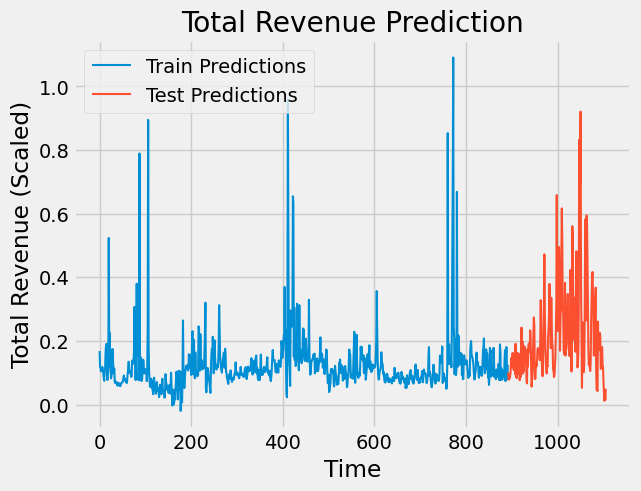

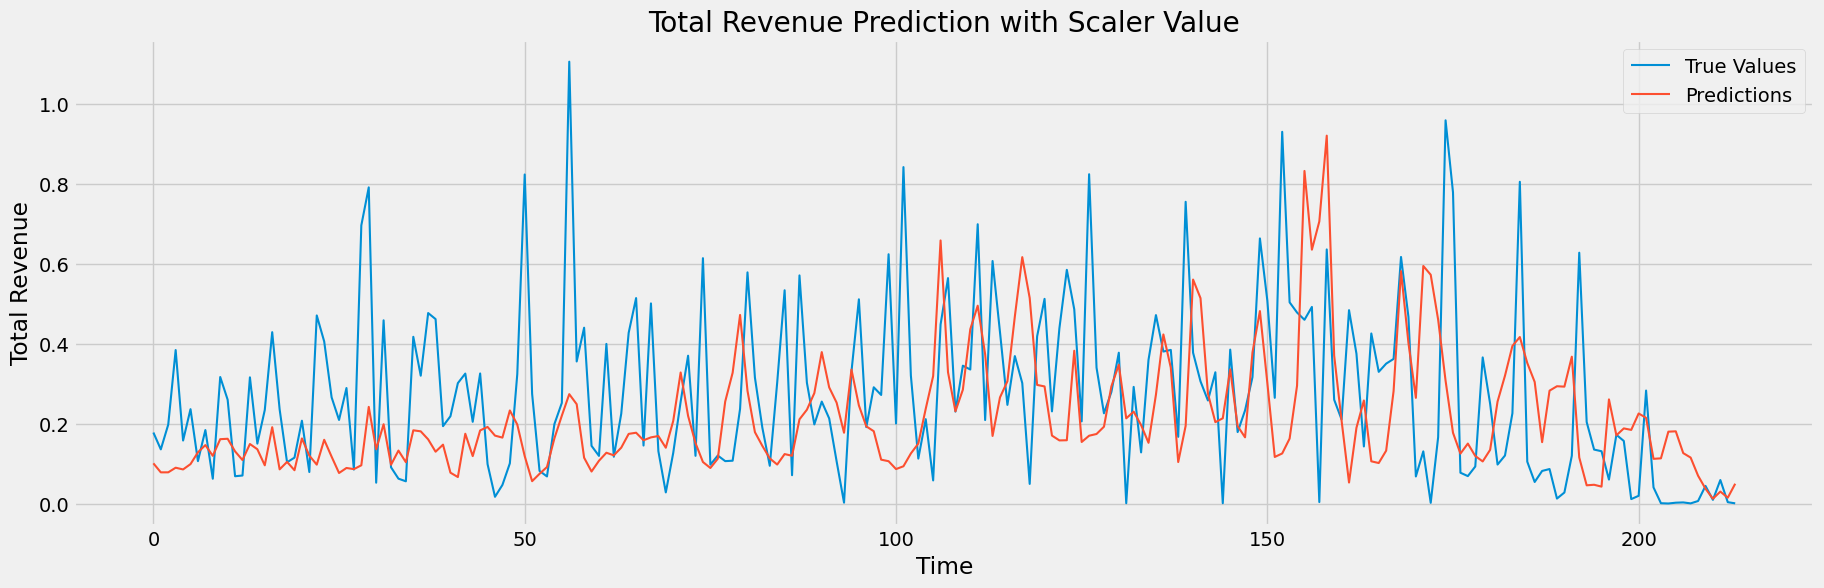

C:\Users\khali\AppData\Local\Temp\ipykernel_7504\1871921201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kode_des['date'] = pd.to_datetime(data_kode_des['date'])  # Convert 'date' column to datetime


Epoch 1/120
27/27 [==============================] - 2s 24ms/step - loss: 0.0049 - val_loss: 0.0067
Epoch 2/120
27/27 [==============================] - 1s 20ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 3/120
27/27 [==============================] - 0s 17ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 4/120
27/27 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 5/120
27/27 [==============================] - 0s 17ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 6/120
27/27 [==============================] - 0s 16ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 7/120
27/27 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 8/120
27/27 [==============================] - 1s 19ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 9/120
27/27 [==============================] - 1s 21ms/step - loss: 0.0040 - val_loss: 0.0063
Epoch 10/120
27/27 [==============================] - 1s 21ms/step - loss: 0.0039 - val_loss: 0.0062

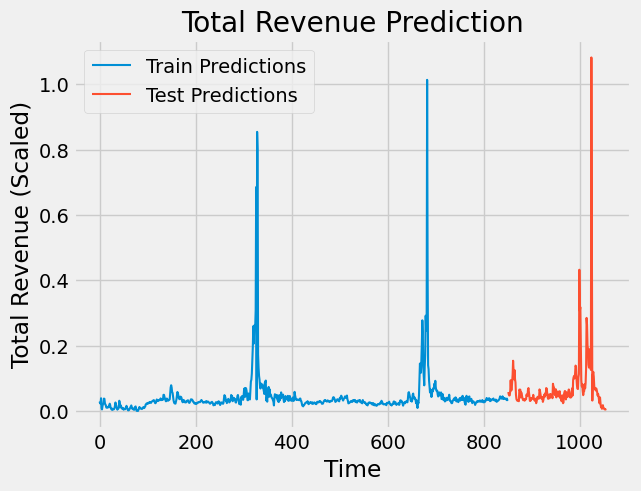

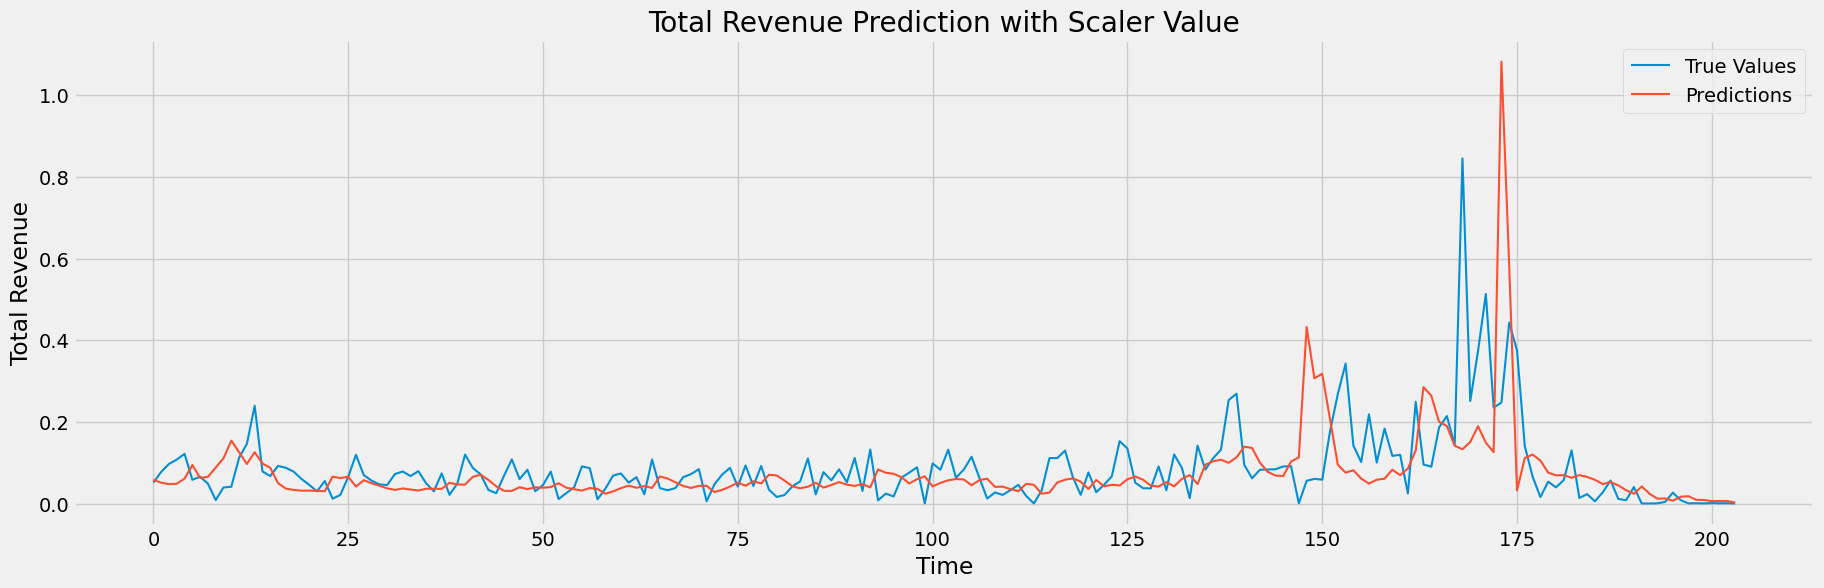

C:\Users\khali\AppData\Local\Temp\ipykernel_7504\1871921201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kode_des['date'] = pd.to_datetime(data_kode_des['date'])  # Convert 'date' column to datetime


Epoch 1/120
27/27 [==============================] - 3s 29ms/step - loss: 0.0155 - val_loss: 0.0255
Epoch 2/120
27/27 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0258
Epoch 3/120
27/27 [==============================] - 0s 17ms/step - loss: 0.0123 - val_loss: 0.0237
Epoch 4/120
27/27 [==============================] - 0s 18ms/step - loss: 0.0123 - val_loss: 0.0242
Epoch 5/120
27/27 [==============================] - 0s 18ms/step - loss: 0.0119 - val_loss: 0.0244
Epoch 6/120
27/27 [==============================] - 0s 18ms/step - loss: 0.0119 - val_loss: 0.0236
Epoch 7/120
27/27 [==============================] - 1s 20ms/step - loss: 0.0119 - val_loss: 0.0234
Epoch 8/120
27/27 [==============================] - 0s 18ms/step - loss: 0.0119 - val_loss: 0.0236
Epoch 9/120
27/27 [==============================] - 0s 18ms/step - loss: 0.0119 - val_loss: 0.0231
Epoch 10/120
27/27 [==============================] - 0s 18ms/step - loss: 0.0120 - val_loss: 0.0252

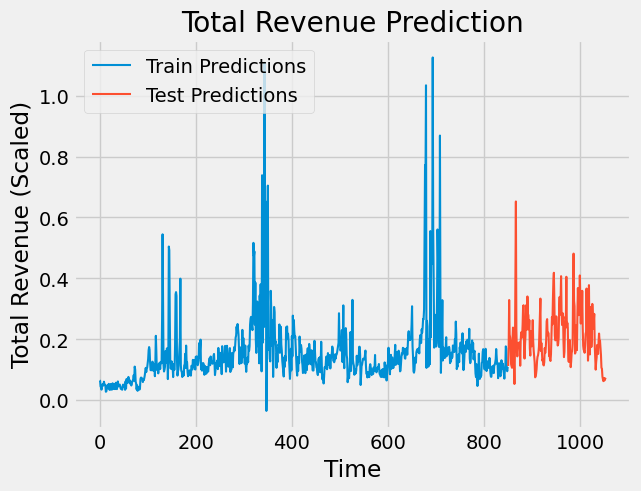

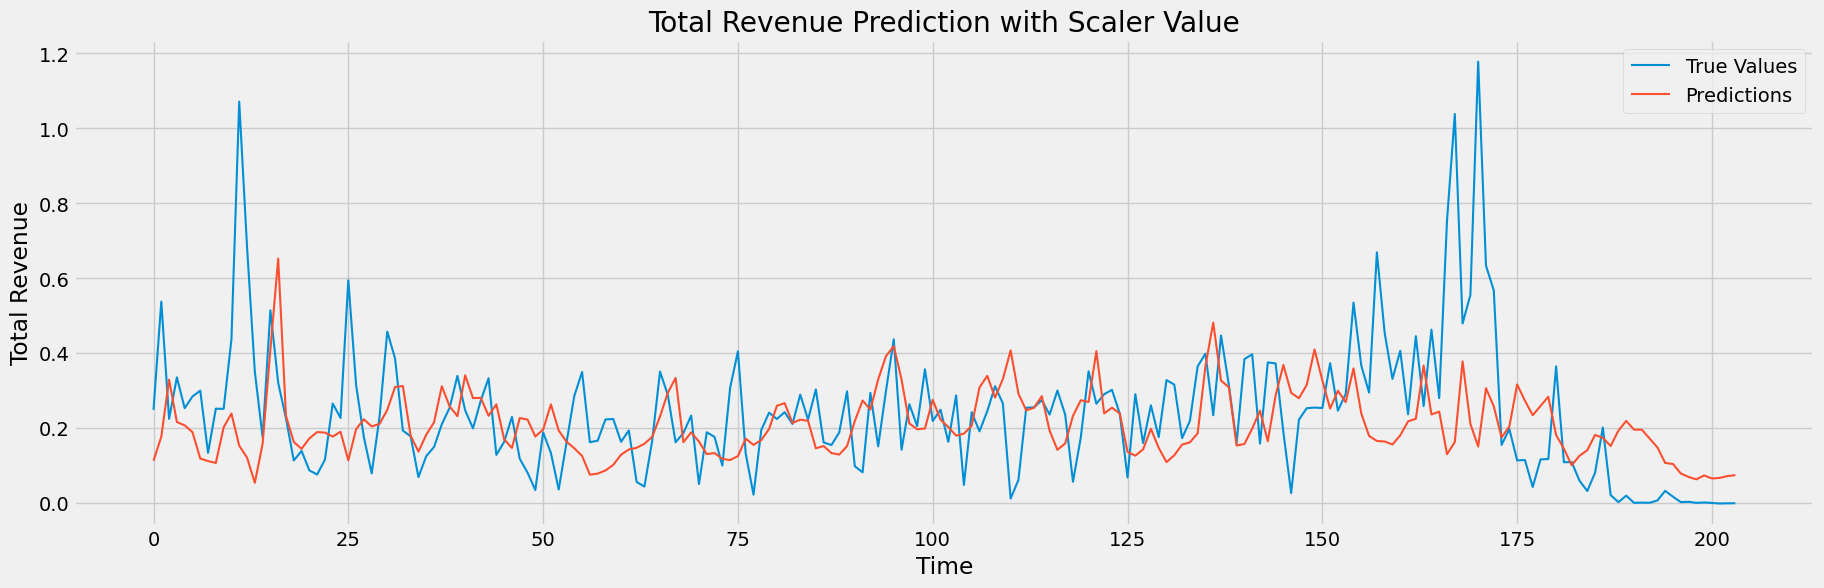

C:\Users\khali\AppData\Local\Temp\ipykernel_7504\1871921201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kode_des['date'] = pd.to_datetime(data_kode_des['date'])  # Convert 'date' column to datetime


Epoch 1/120
26/26 [==============================] - 2s 27ms/step - loss: 0.0120 - val_loss: 0.0140
Epoch 2/120
26/26 [==============================] - 1s 20ms/step - loss: 0.0095 - val_loss: 0.0130
Epoch 3/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0094 - val_loss: 0.0136
Epoch 4/120
26/26 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0131
Epoch 5/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0091 - val_loss: 0.0129
Epoch 6/120
26/26 [==============================] - 0s 17ms/step - loss: 0.0090 - val_loss: 0.0128
Epoch 7/120
26/26 [==============================] - 1s 20ms/step - loss: 0.0092 - val_loss: 0.0127
Epoch 8/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0093 - val_loss: 0.0128
Epoch 9/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0089 - val_loss: 0.0127
Epoch 10/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0091 - val_loss: 0.0130

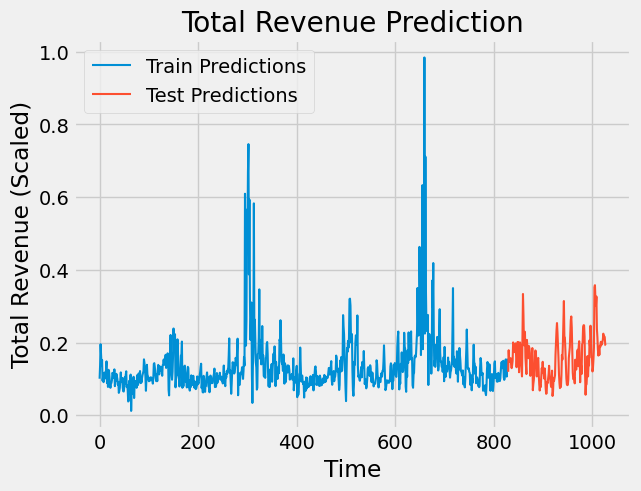

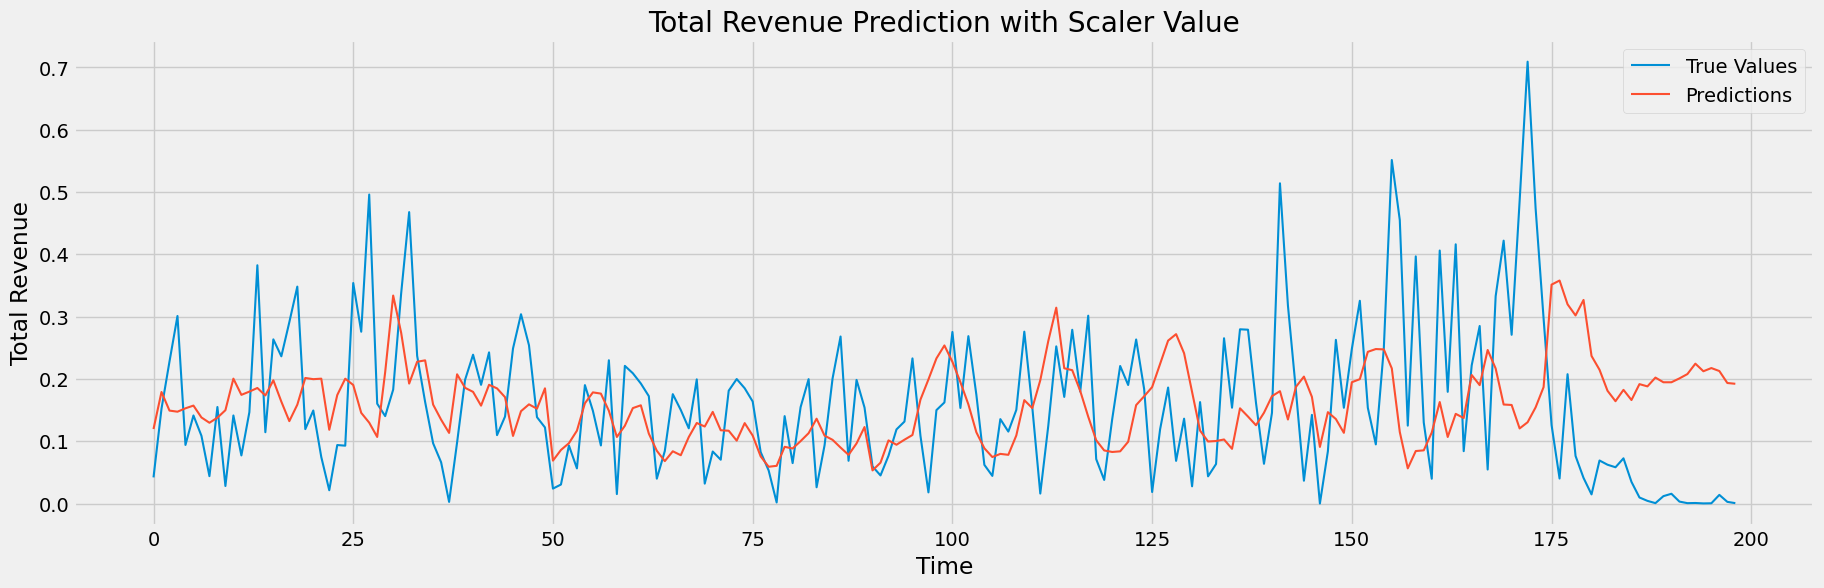

C:\Users\khali\AppData\Local\Temp\ipykernel_7504\1871921201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kode_des['date'] = pd.to_datetime(data_kode_des['date'])  # Convert 'date' column to datetime


Epoch 1/120
26/26 [==============================] - 2s 29ms/step - loss: 0.0179 - val_loss: 0.0186
Epoch 2/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0152 - val_loss: 0.0203
Epoch 3/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0151 - val_loss: 0.0186
Epoch 4/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0152 - val_loss: 0.0184
Epoch 5/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0148 - val_loss: 0.0182
Epoch 6/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0148 - val_loss: 0.0191
Epoch 7/120
26/26 [==============================] - 0s 17ms/step - loss: 0.0150 - val_loss: 0.0179
Epoch 8/120
26/26 [==============================] - 1s 21ms/step - loss: 0.0145 - val_loss: 0.0177
Epoch 9/120
26/26 [==============================] - 0s 18ms/step - loss: 0.0149 - val_loss: 0.0187
Epoch 10/120
26/26 [==============================] - 0s 19ms/step - loss: 0.0148 - val_loss: 0.0173

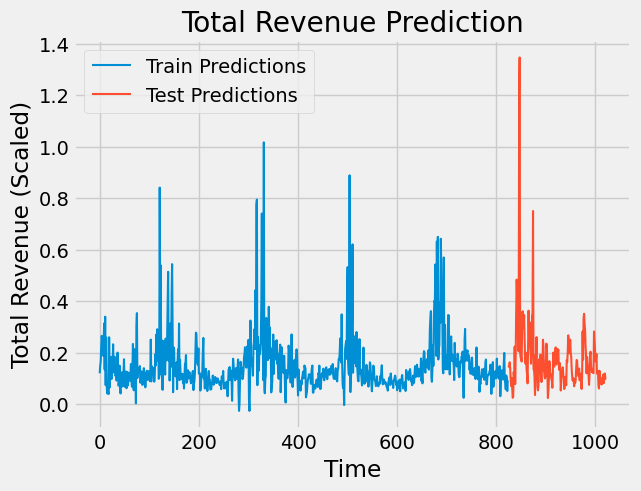

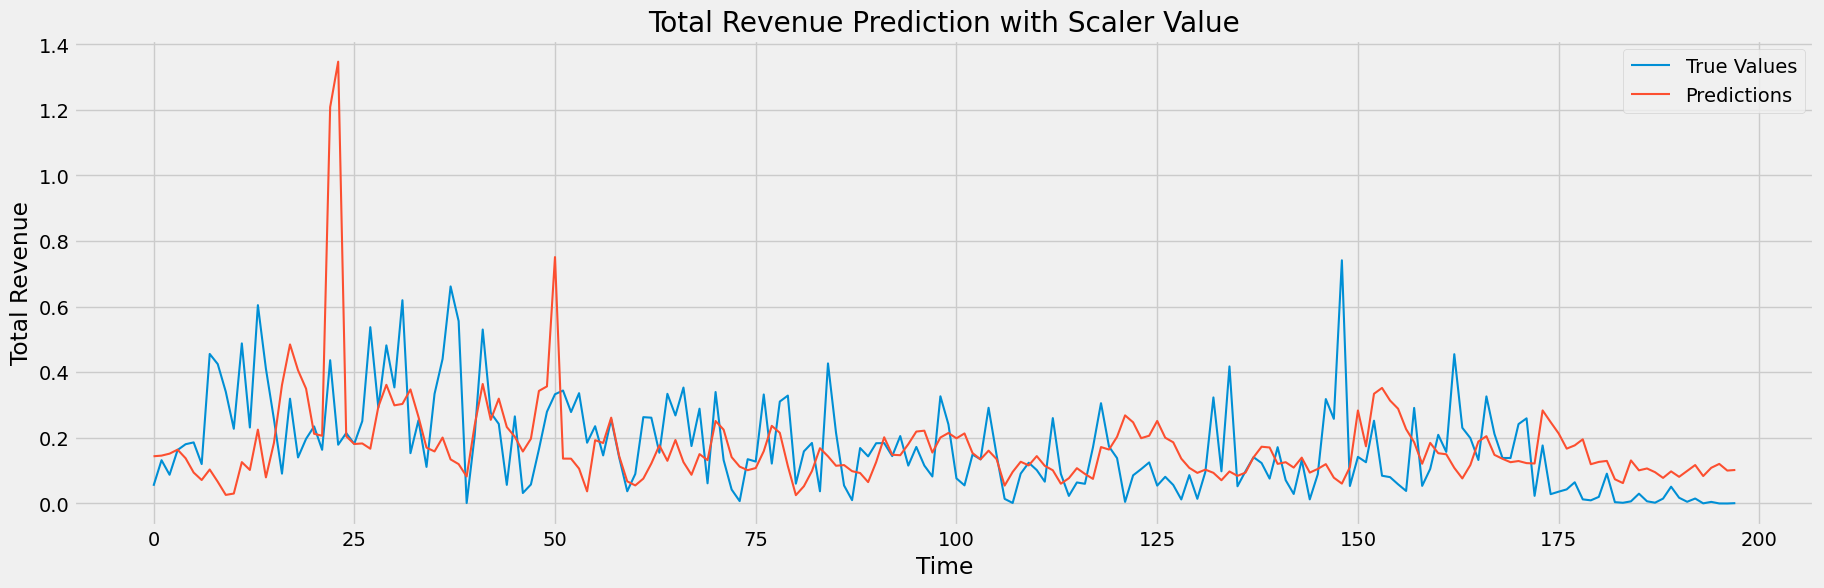

In [23]:
for kode_des in kode_des_values:
    data_kode_des = grouped_df.loc[grouped_df['kode_des'] == kode_des] 

    # Filter the data from 2015 to 2019
    data_kode_des['date'] = pd.to_datetime(data_kode_des['date'])  # Convert 'date' column to datetime
    data_kode_des = data_kode_des.set_index('date')  # Set 'date' column as the index
    data_kode_des = data_kode_des.loc['2015-01-01':'2019-12-31']  # Filter based on date range
    data_kode_des = data_kode_des.reset_index()

    # Select the features and target variable
    features = ['avg_revenue', 'ship_count', 'hijri_month']
    target = ['total_revenue']

    # Create a new DataFrame with the selected columns
    new_data = data_kode_des[features + target]

    # Splitting Data
    train_ratio = 0.8
    test_ratio = 0.2

    split_index = int(len(new_data) * train_ratio)

    train_data = new_data[:split_index]
    test_data = new_data[split_index:]

    # Separate the features and target variable for training and testing
    X_train = train_data[features]
    y_train = train_data[target]

    X_test = test_data[features]
    y_test = test_data[target]

    # Apply MinMaxScaler for normalization
    scaler = MinMaxScaler()

    # Fit the scaler on the training features
    scaler.fit(X_train)

    # Apply the scaler to both training and test features
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Normalize the target variable separately
    y_scaler = MinMaxScaler()

    # Fit the scaler on the training target variable
    y_scaler.fit(y_train)

    # Apply the scaler to both training and test target variable
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    # Define the number of time steps and features
    n_steps = 12  # Number of time steps (input sequence length)
    n_features = X_train_scaled.shape[1]  # Number of features (columns)

    # Create input-output pairs for training and testing
    def create_sequences(X, y, n_steps):
        X_seq, y_seq = [], []
        for i in range(len(X) - n_steps):
            X_seq.append(X[i:i + n_steps])
            y_seq.append(y[i + n_steps])
        return np.array(X_seq), np.array(y_seq)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Train the model
    model.fit(X_train_seq, y_train_seq, epochs=120, batch_size=32, validation_data=(X_test_seq, y_test_seq))

    # Evaluate the model
    y_train_pred = model.predict(X_train_seq)
    y_test_pred = model.predict(X_test_seq)

    # Calculate the root mean squared error (RMSE) with scaled value
    train_rmse = np.sqrt(np.mean((y_train_seq - y_train_pred) ** 2))
    test_rmse = np.sqrt(np.mean((y_test_seq - y_test_pred) ** 2))
    print('KODE_DES : ',kode_des)
    print("Train RMSE with Scaler Value:", train_rmse)
    print("Test RMSE with Scaler Value:", test_rmse)

    # Plot the training predictions
    plt.plot(y_train_pred, label='Train Predictions')

    # Plot the test predictions
    plt.plot(len(y_train_pred) + np.arange(len(y_test_pred)), y_test_pred, label='Test Predictions')

    plt.xlabel('Time')
    plt.ylabel('Total Revenue (Scaled)')
    plt.title('Total Revenue Prediction')
    plt.legend()
    plt.show()

    # Plot the predictions
    plt.figure(figsize=(20, 6))
    plt.plot(y_test_seq, label='True Values')
    plt.plot(y_test_pred, label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Total Revenue')
    plt.title('Total Revenue Prediction with Scaler Value')
    plt.legend()
    plt.show()

    # # Inverse transform the scaled predictions and true values
    # y_train_pred_inv = y_scaler.inverse_transform(y_train_pred)
    # y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)
    # y_train_true_inv = y_scaler.inverse_transform(y_train_seq)
    # y_test_true_inv = y_scaler.inverse_transform(y_test_seq)

    # # Calculate the root mean squared error (RMSE)
    # train_rmse = np.sqrt(np.mean((y_train_true_inv - y_train_pred_inv) ** 2))
    # test_rmse = np.sqrt(np.mean((y_test_true_inv - y_test_pred_inv) ** 2))
    # # Calculate the mean of the original values
    # mean_original = np.mean(y_test_true_inv)

    # print("Train RMSE with Actual Value:", train_rmse)
    # print("Test RMSE with Actual Value:", test_rmse)
    # print("test original value : ", mean_original)

    # # Plot the predictions
    # plt.figure(figsize=(20, 6))
    # plt.plot(y_test_true_inv, label='True Values')
    # plt.plot(y_test_pred_inv, label='Predictions')
    # plt.xlabel('Time')
    # plt.ylabel('Total Revenue')
    # plt.title('Total Revenue Prediction with Actual Value')
    # plt.legend()
    # plt.show()

PEMBATAS

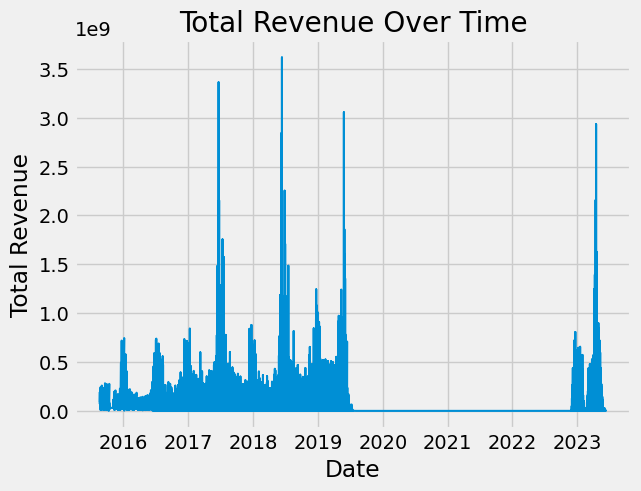

In [75]:
plt.plot(grouped_df['date'], grouped_df['total_revenue'])
plt.title('Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.show()

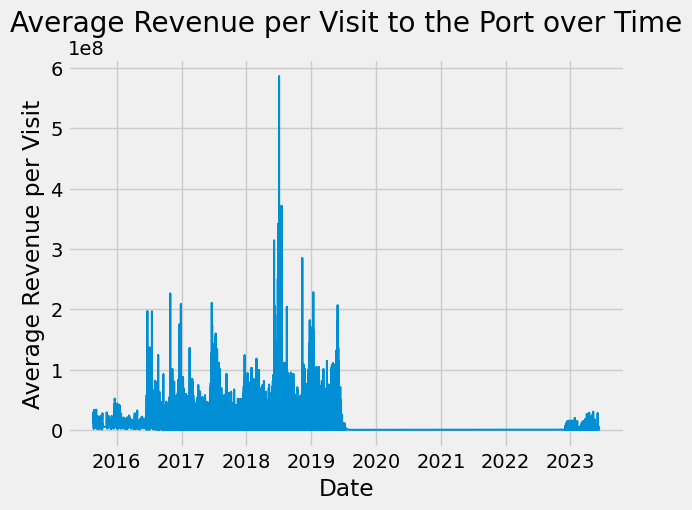

In [76]:
avg_revenue_per_visit = grouped_df['avg_revenue'] 

# Create a line plot of the average revenue per visit over time
plt.plot(grouped_df['date'], avg_revenue_per_visit)
plt.xlabel('Date')
plt.ylabel('Average Revenue per Visit')
plt.title('Average Revenue per Visit to the Port over Time')
plt.show()

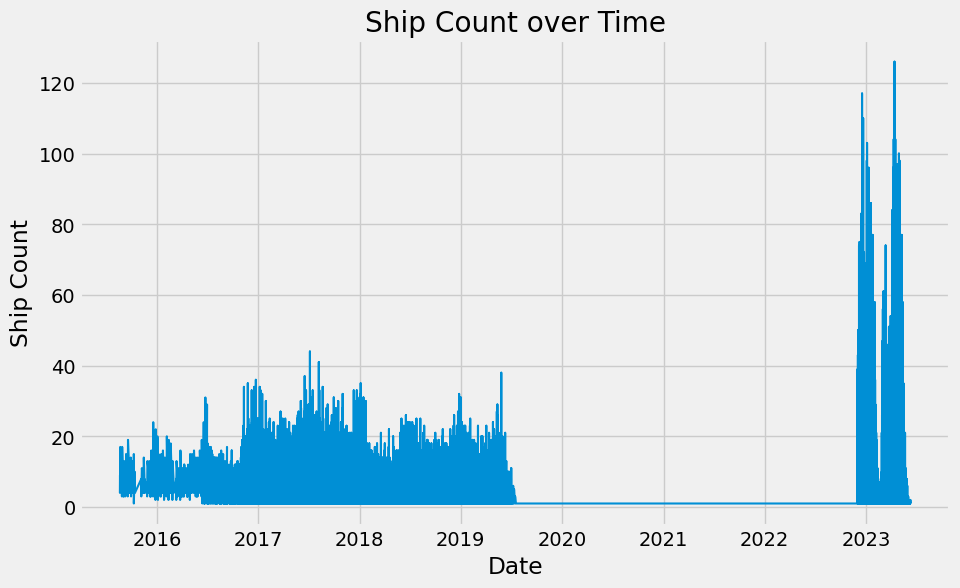

In [77]:
# Create a new figure
plt.figure(figsize=(10, 6))
plt.plot(grouped_df['date'], grouped_df['ship_count'])
plt.title('Ship Count over Time')
plt.xlabel('Date')
plt.ylabel('Ship Count')
plt.show()

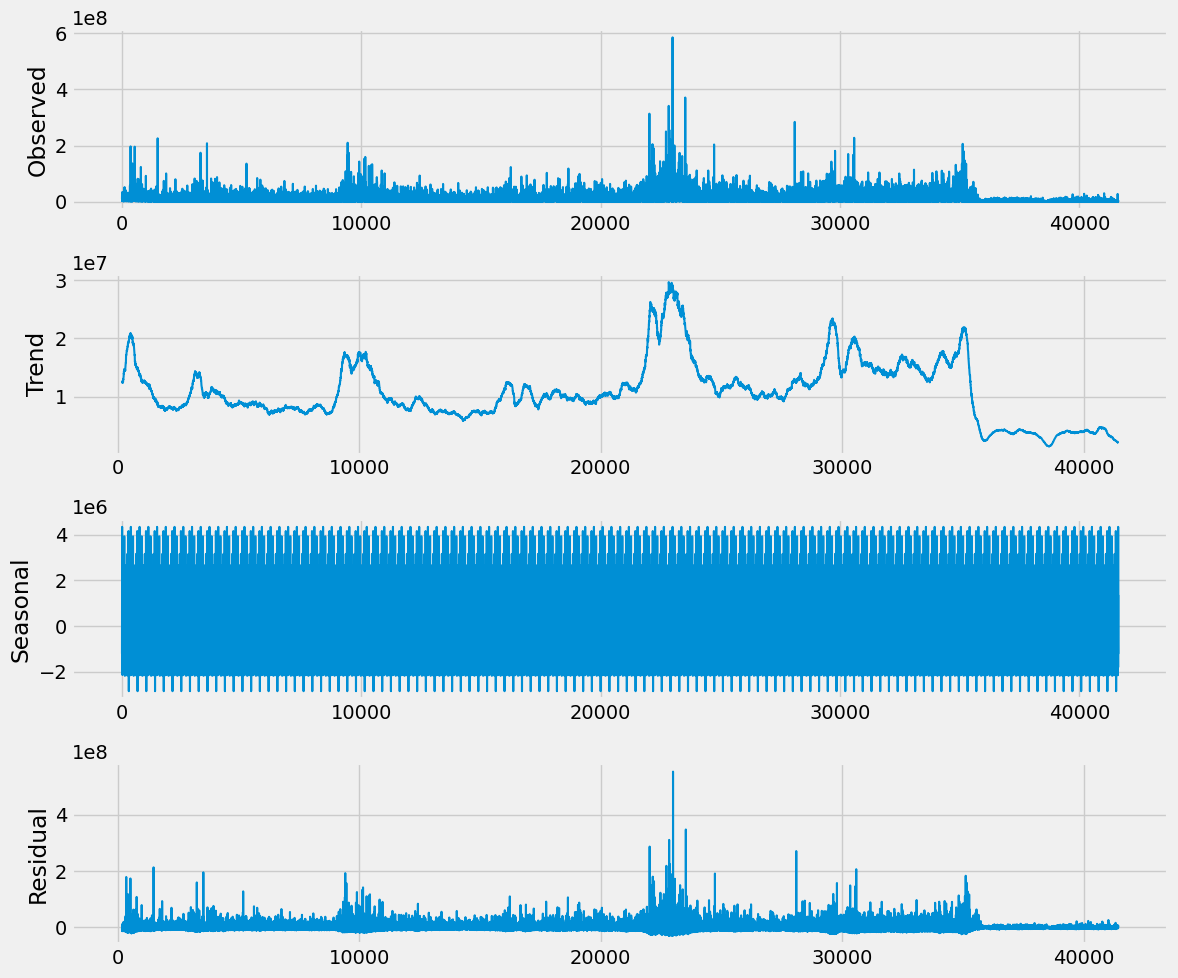

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into its components
decomposition = seasonal_decompose(avg_revenue_per_visit, period=365)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

<Axes: >

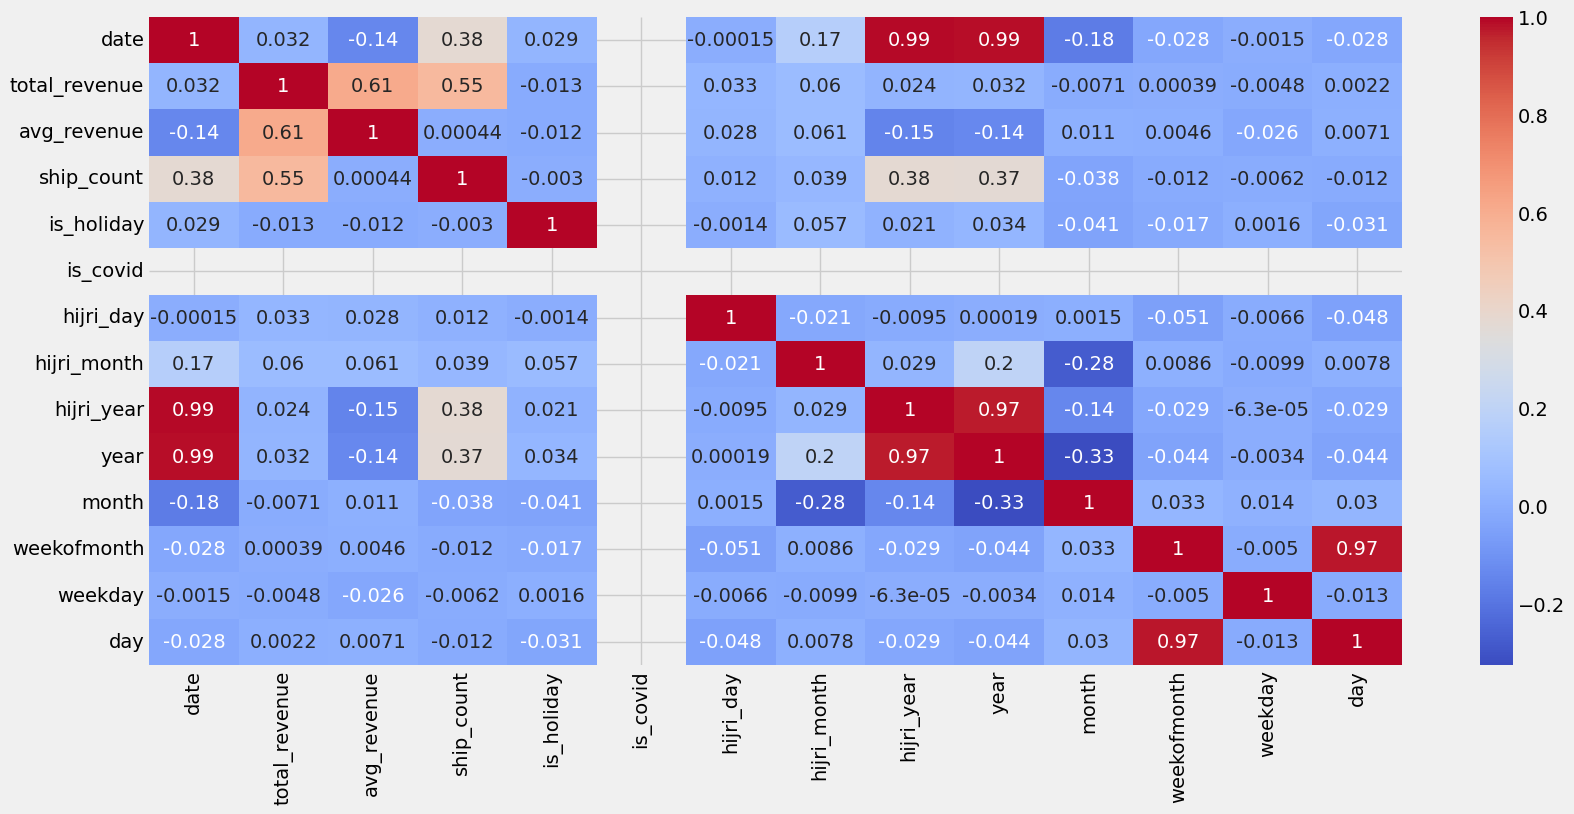

In [79]:
import seaborn as sns


# Set the figure size
plt.figure(figsize=(18,8))

# Calculate the correlation matrix
corr_matrix = grouped_df[['date','total_revenue', 'avg_revenue', 'ship_count', 'is_holiday','is_covid','hijri_day', 'hijri_month', 'hijri_year', 'year', 'month', 'weekofmonth', 'weekday','day']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [80]:
data_431 = grouped_df.loc[grouped_df['kode_des'] == 431] 
# Filter the data from 2015 to 2019
data_431['date'] = pd.to_datetime(data_431['date'])  # Convert 'date' column to datetime
data_431 = data_431.set_index('date')  # Set 'date' column as the index
data_431 = data_431.loc['2015-01-01':'2019-12-31']  # Filter based on date range
data_431 = data_431.reset_index()
data_431

C:\Users\khali\AppData\Local\Temp\ipykernel_9072\2319150780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_431['date'] = pd.to_datetime(data_431['date'])  # Convert 'date' column to datetime


,date,kode_des,total_revenue,avg_revenue,ship_count,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day,is_holiday,is_covid
0,2015-08-25,431,123506000,1.764371e+07,7,2015,8,25,1,4,1436,11,10,0,0
1,2015-08-26,431,27001000,4.500167e+06,6,2015,8,26,2,4,1436,11,11,0,0
2,2015-09-01,431,87616500,1.460275e+07,6,2015,9,1,1,1,1436,11,17,0,0
3,2015-09-02,431,20061000,6.687000e+06,3,2015,9,2,2,1,1436,11,18,0,0
4,2015-09-08,431,78201500,1.303358e+07,6,2015,9,8,1,2,1436,11,24,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2019-07-02,431,27029000,2.457182e+06,11,2019,7,2,1,1,1440,10,29,0,0
1126,2019-07-03,431,5977000,1.992333e+06,3,2019,7,3,2,1,1440,10,30,0,0
1127,2019-07-09,431,35902000,5.983667e+06,6,2019,7,9,1,2,1440,11,6,0,0
1128,2019-07-16,431,2436000,8.120000e+05,3,2019,7,16,1,3,1440,11,13,0,0


<Axes: >

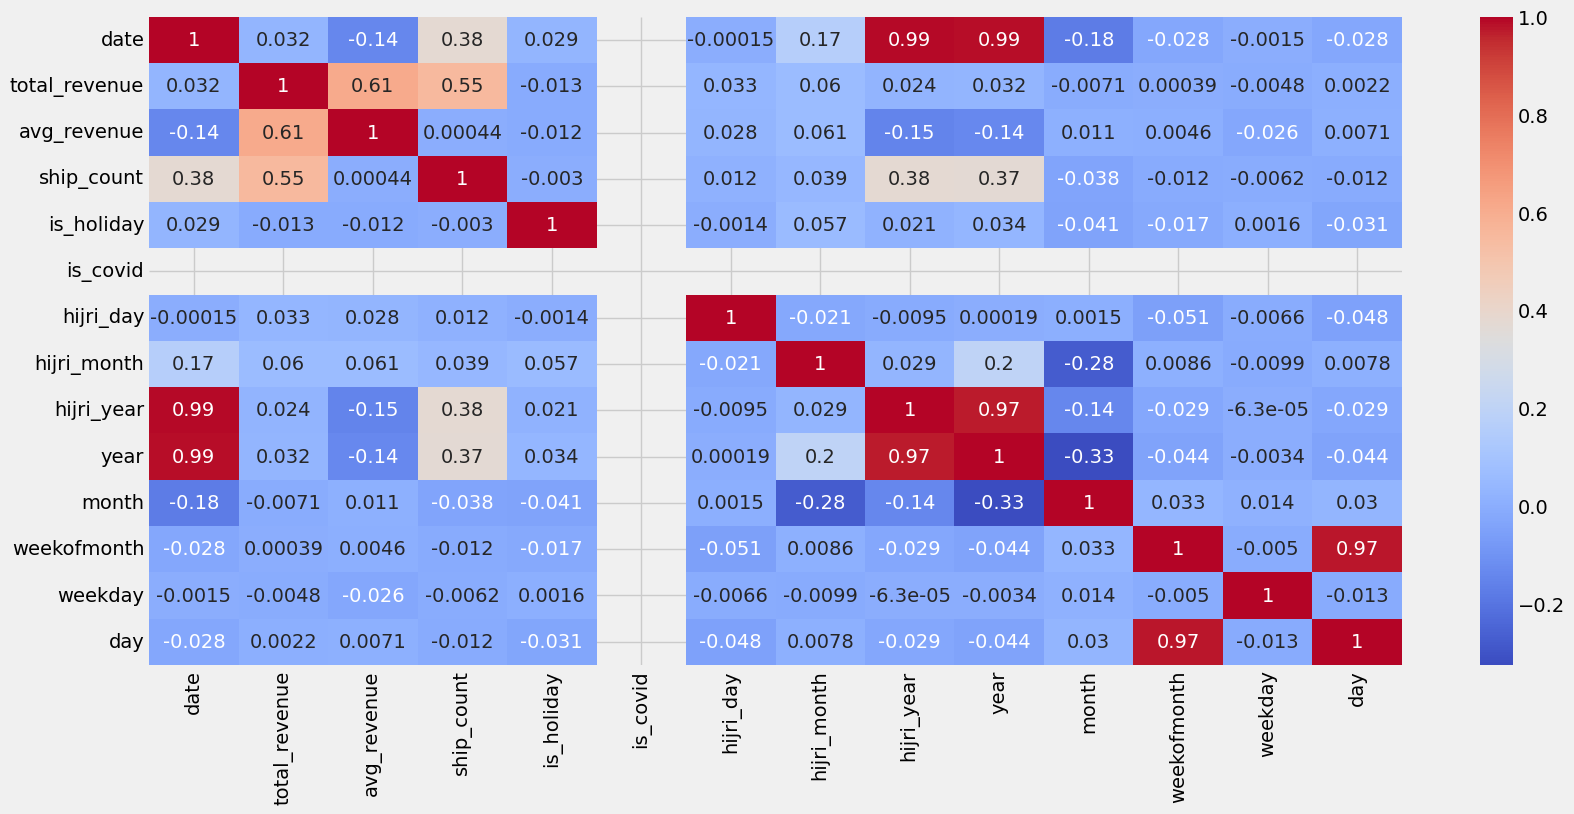

In [81]:
plt.figure(figsize=(18,8))
corr_matrix_431 = data_431[['date','total_revenue', 'avg_revenue', 'ship_count', 'is_holiday', 'hijri_day', 'hijri_month', 'hijri_year', 'year', 'month', 'weekofmonth', 'weekday', 'is_covid']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [82]:
# #ELIMINASI OUTLIERS
# #Deteksi pakai Interquartile Range (IQR):
# Q1 = data_431.quantile(0.25)
# Q3 = data_431.quantile(0.75)
# IQR = Q3 - Q1

# # Remove outliers using the IQR method
# data_431 = data_431[~((data_431 < (Q1 - 1.5 * IQR)) | (data_431 > (Q3 + 1.5 * IQR))).any(axis=1)]
# data_431

In [83]:
# # Interpolate missing values
# data_interpolated = data_431.interpolate()

# # Check if there are any remaining missing values
# print(data_interpolated.isnull().sum())

In [84]:
# len(data_interpolated)

In [85]:
# Select the desired columns
# data_interpolated = data_interpolated.reset_index()
# data_y = data_interpolated['total_revenue']
# data_y.head()

# new_data = data_interpolated[['date','avg_revenue', 'ship_count', 'hijri_month', 'hijri_day', 'hijri_year','total_revenue']]
# new_data = data_interpolated[['avg_revenue', 'ship_count', 'hijri_month','total_revenue']]
# new_data = data_431[['avg_revenue', 'ship_count', 'hijri_month']]
# # new_data = new_data.set_index(['avg_revenue', 'ship_count', 'hijri_month'])
# new_data


In [86]:
# Select the features and target variable
features = ['avg_revenue', 'ship_count', 'hijri_month']
target = ['total_revenue']

# Create a new DataFrame with the selected columns
new_data = data_431[features + target]

# Splitting Data
train_ratio = 0.8
test_ratio = 0.2

split_index = int(len(new_data) * train_ratio)

train_data = new_data[:split_index]
test_data = new_data[split_index:]

# Separate the features and target variable for training and testing
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [87]:
#MINMAXSCALER


# Apply MinMaxScaler for normalization
# scaler = StandardScaler()
scaler = MinMaxScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable separately
y_scaler = MinMaxScaler()

# Fit the scaler on the training target variable
y_scaler.fit(y_train)

# Apply the scaler to both training and test target variable
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [129]:
#Creating RNN MODEL

# Define the number of time steps and features
n_steps = 12 # Number of time steps (input sequence length)
n_features = X_train_scaled.shape[1]  # Number of features (columns)

# Create input-output pairs for training and testing
def create_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i + n_steps])
        y_seq.append(y[i + n_steps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

# Build the LSTM model
model = Sequential()
model.add(LSTM(200, activation= 'relu',input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model
model.fit(X_train_seq, y_train_seq, epochs=120, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/120
28/28 [==============================] - 3s 31ms/step - loss: 0.0171 - val_loss: 0.0663
Epoch 2/120
28/28 [==============================] - 0s 15ms/step - loss: 0.0151 - val_loss: 0.0706
Epoch 3/120
28/28 [==============================] - 0s 16ms/step - loss: 0.0149 - val_loss: 0.0652
Epoch 4/120
28/28 [==============================] - 0s 15ms/step - loss: 0.0150 - val_loss: 0.0708
Epoch 5/120
28/28 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0659
Epoch 6/120
28/28 [==============================] - 0s 15ms/step - loss: 0.0146 - val_loss: 0.0571
Epoch 7/120
28/28 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0574
Epoch 8/120
28/28 [==============================] - 0s 14ms/step - loss: 0.0147 - val_loss: 0.0602
Epoch 9/120
28/28 [==============================] - 0s 17ms/step - loss: 0.0145 - val_loss: 0.0552
Epoch 10/120
28/28 [==============================] - 0s 16ms/step - loss: 0.0146 - val_loss: 0.0658

7/7 [==============================] - 0s 5ms/step
Train RMSE with Scaler Value: 0.08756518491523053
Test RMSE with Scaler Value: 0.23866846973243547


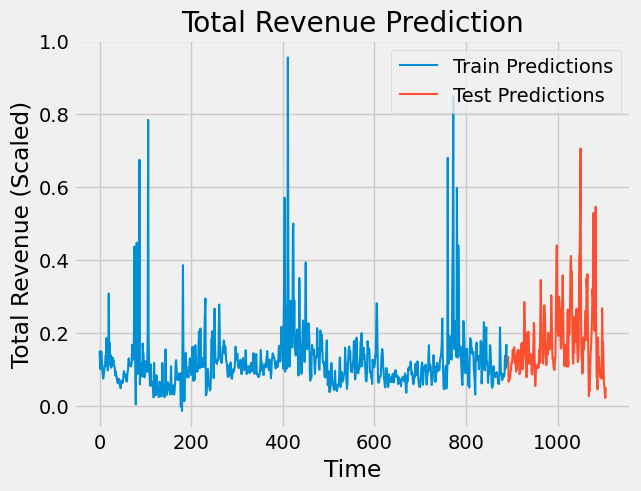

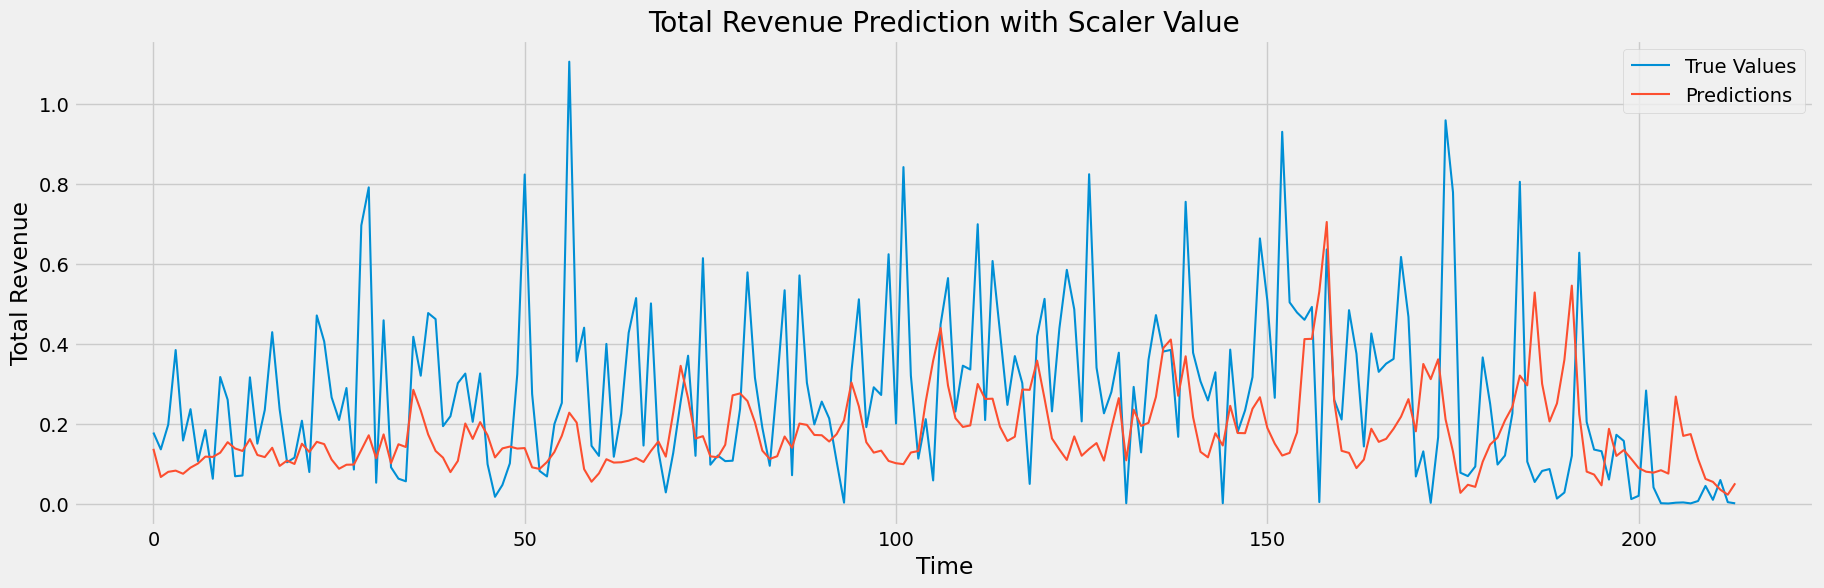

Train RMSE with Actual Value: 52856709.8694452
Test RMSE with Actual Value: 144066730.84770685
test original value :  166482252.3364486


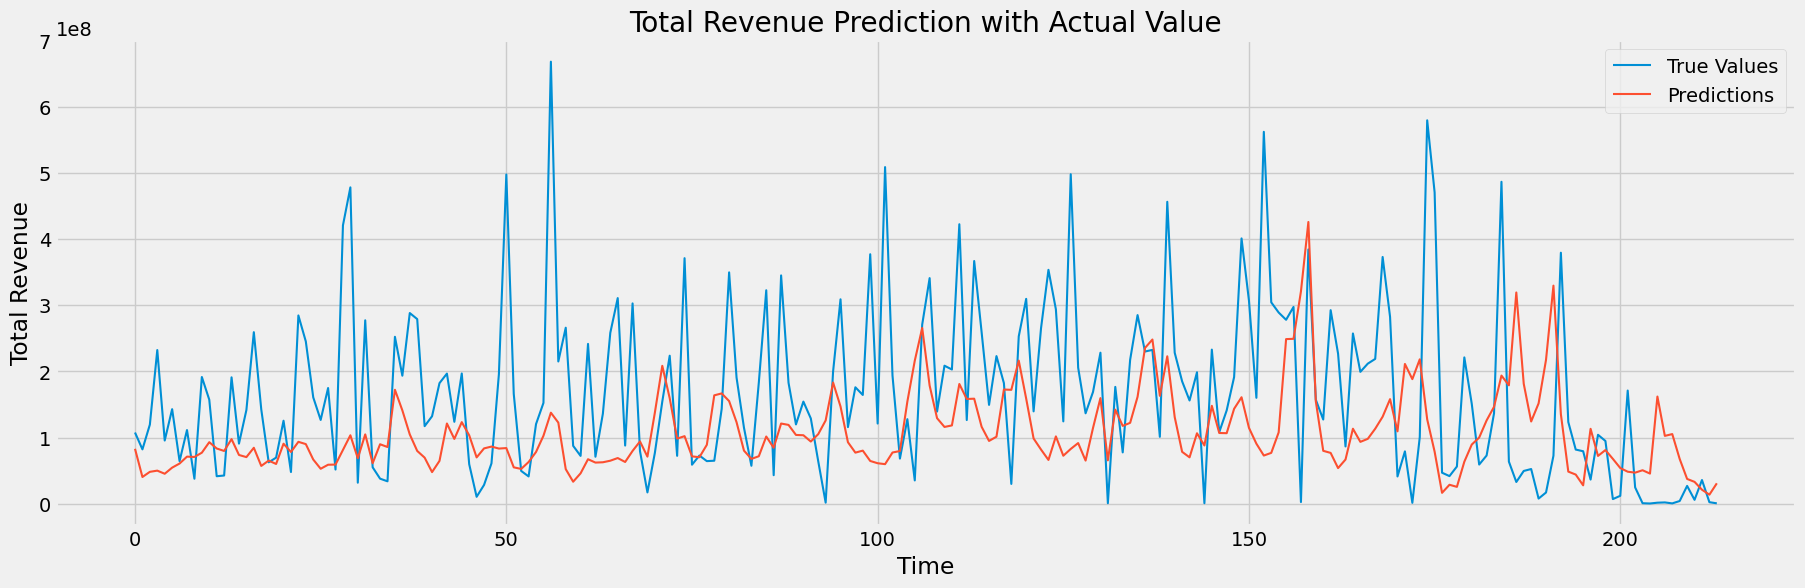

In [131]:
#Evaluate the model
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Calculate the root mean squared error (RMSE) with scaled value
train_rmse = np.sqrt(np.mean((y_train_seq - y_train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test_seq - y_test_pred) ** 2))

print("Train RMSE with Scaler Value:", train_rmse)
print("Test RMSE with Scaler Value:", test_rmse)

# Plot the training predictions
plt.plot(y_train_pred, label='Train Predictions')


# Plot the test predictions
plt.plot(len(y_train_pred) + np.arange(len(y_test_pred)), y_test_pred, label='Test Predictions')

plt.xlabel('Time')
plt.ylabel('Total Revenue (Scaled)')
plt.title('Total Revenue Prediction')
plt.legend()
plt.show()

# Plot the predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test_seq, label='True Values')
plt.plot(y_test_pred, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Total Revenue')
plt.title('Total Revenue Prediction with Scaler Value')
plt.legend()
plt.show()

#-------------------------------------------------------------------------------------------------------------


# Inverse transform the scaled predictions and true values
y_train_pred_inv = y_scaler.inverse_transform(y_train_pred)
y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)
y_train_true_inv = y_scaler.inverse_transform(y_train_seq)
y_test_true_inv = y_scaler.inverse_transform(y_test_seq)

# Calculate the root mean squared error (RMSE)
train_rmse = np.sqrt(np.mean((y_train_true_inv - y_train_pred_inv) ** 2))
test_rmse = np.sqrt(np.mean((y_test_true_inv - y_test_pred_inv) ** 2))
# Calculate the mean of the original values
mean_original = np.mean(y_test_true_inv)

print("Train RMSE with Actual Value:", train_rmse)
print("Test RMSE with Actual Value:", test_rmse)
print("test original value : ", mean_original )

# Plot the predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test_true_inv, label='True Values')
plt.plot(y_test_pred_inv, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Total Revenue')
plt.title('Total Revenue Prediction with Actual Value')
plt.legend()
plt.show()